## Analysis

In [1]:
import numpy as np
import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

from keras.models import load_model

from predict import predict

import fsps

Using TensorFlow backend.


Initialise FSPS

In [2]:
fsp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1,
                             sfh=3, logzsol=0.0, dust_type=2, dust2=0.0, 
                             add_neb_emission=True)

prediction = {}

Load sims / obs

In [3]:
sv = predict(fname='data/vespa_histories.h5', redshift = 0.1)

Load sim data

In [4]:
name = 'illustris_hmass'
sn = 50

si = predict(fname='data/full_histories_illustris.h5')

illustris_dust, wl = si.load_spectra('Dust')
illustris_dust_noise = si.add_noise_flat(spec=illustris_dust, wl=wl, sn=sn)
si.generate_standardisation(key='Dust Noise SN50', spec=illustris_dust_noise)

name = 'eagle_hmass'

se = predict(fname='data/full_histories_eagle.h5')

eagle_dust, wl = se.load_spectra('Dust')
eagle_dust_noise = se.add_noise_flat(spec=eagle_dust, wl=wl, sn=sn)
se.generate_standardisation(key='Dust Noise SN50', spec=eagle_dust_noise)

In [5]:
emask, imask = pcl.load(open('data/sim_selection_masks.p', 'rb'))

Apply illustris model to SDSS

In [6]:
sdss_spec, wl = sv.load_spectra('SDSS')
# sv.generate_standardisation(key='SDSS', spec=sdss_spec)

features = sv.prepare_features(sdss_spec, scaler=si.scalers['Dust Noise SN50'],
                               key='SDSS', CNN=True)

cnn_model = load_model('data/cnn_trained_illustris_dust_noise50_x4.h5', 
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction['illustris'] = cnn_model.predict(features)

features = si.prepare_features(illustris_dust_noise, key='Dust Noise SN50', CNN=True)[imask]
prediction['illustris-train'] = cnn_model.predict(features)

Apply EAGLE model to SDSS

In [7]:
features = sv.prepare_features(sdss_spec, scaler=se.scalers['Dust Noise SN50'],
                               key='SDSS', CNN=True)

cnn_model = load_model('data/cnn_trained_eagle_dust_noise50_x4.h5', 
                       custom_objects={'_SMAPE_tf': se._SMAPE_tf})

prediction['eagle'] = cnn_model.predict(features)

features = se.prepare_features(eagle_dust_noise, key='Dust Noise SN50', CNN=True)[emask]
prediction['eagle-train'] = cnn_model.predict(features)

Prepare VESPA histories

In [8]:
predictors = sv.load_arr('vespa','SFH')

Get binnings

In [43]:
bins = si.load_arr('bins','bins/log_8')
binLimits = si.load_arr('binLimits','bins/log_8')
binWidths = si.load_arr('binWidths','bins/log_8')

vbins = sv.load_arr('bins','bins/vespa_bins')
vbinLimits = sv.load_arr('binLimits','bins/vespa_bins')
vbinWidths = sv.load_arr('binWidths','bins/vespa_bins')

Plot spectra

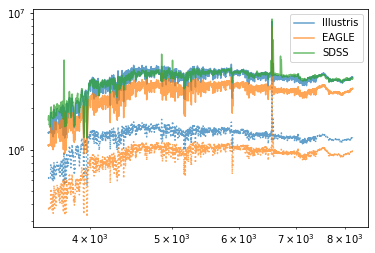

In [44]:
plt.semilogx(wl, np.median(illustris_dust_noise, axis=0), 
           alpha=0.7, c='C0', ls='dotted')

plt.semilogx(wl, np.median(illustris_dust_noise[imask], axis=0), 
           alpha=0.7, c='C0', label='Illustris')

plt.loglog(wl, np.median(eagle_dust_noise, axis=0), 
           alpha=0.7, c='C1', ls='dotted')

plt.loglog(wl, np.median(eagle_dust_noise[emask], axis=0), 
           alpha=0.7, c='C1', label='EAGLE')

plt.semilogx(wl, np.median(sdss_spec, axis=0), label='SDSS', alpha=0.7, c='C2')

plt.legend()

Mean history

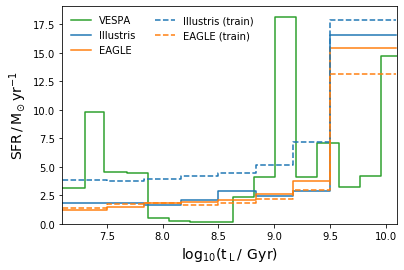

In [45]:
fig, ax = plt.subplots(1,1)

perc = np.mean(predictors, axis=0)
perc = np.hstack([perc, np.array([perc[-1]]).T])
ax.step(np.log10(vbinLimits * 1e9), perc, label='VESPA', where='post', color='C2')

perc = np.mean(prediction['illustris'], axis=0)
perc = np.hstack([perc, np.array([perc[-1]]).T])
ax.step(np.log10(binLimits * 1e9), perc, label='Illustris', where='post', color='C0')

perc = np.mean(prediction['eagle'], axis=0)
perc = np.hstack([perc, np.array([perc[-1]]).T])
ax.step(np.log10(binLimits * 1e9), perc, label='EAGLE', where='post', color='C1')

perc = np.mean(prediction['illustris-train'], axis=0)
perc = np.hstack([perc, np.array([perc[-1]]).T])
ax.step(np.log10(binLimits * 1e9), perc, label='Illustris (train)', 
         where='post', color='C0', linestyle='dashed')

perc = np.mean(prediction['eagle-train'], axis=0)
perc = np.hstack([perc, np.array([perc[-1]]).T])
ax.step(np.log10(binLimits * 1e9), perc, label='EAGLE (train)', 
         where='post', color='C1', linestyle='dashed')


ax.set_ylim(0,)
ax.set_xlim(7.1,10.1)

ax.set_xlabel('$\mathrm{log_{10}(t_{\,L} \,/\, \;Gyr)}$', size=14)
ax.set_ylabel('$\mathrm{SFR \,/\, M_{\odot} \, yr^{-1}}$', size=14)

ax.legend(loc=2, frameon=False, ncol=2)

# fig.savefig('plots/ensemble_average_SDSS.png', dpi=250, bbox_inches='tight')

### Recycling fraction

In [46]:
recycling_fraction = np.array([None] * len(bins), dtype=float)
for i,t in enumerate(binLimits[1:]):
    fsp.get_spectrum(tage=t);
    recycling_fraction[i] = fsp.stellar_mass
    
recycling_fraction_vespa = np.array([None] * len(vbins), dtype=float)
for i,t in enumerate(vbinLimits[1:]):
    fsp.get_spectrum(tage=t);
    recycling_fraction_vespa[i] = fsp.stellar_mass


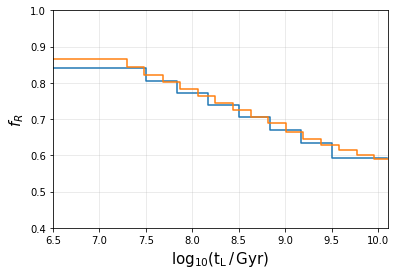

In [47]:
rf = np.hstack([recycling_fraction[0],recycling_fraction])
plt.step(np.log10(binLimits * 1e9), rf)

rf = np.hstack([recycling_fraction_vespa[0],recycling_fraction_vespa])
plt.step(np.log10(vbinLimits * 1e9), rf)

plt.xlim(6.5,10.1)
plt.xlabel('$\mathrm{log_{10}(t_{L} \,/\, Gyr)}$', size=15)
plt.ylabel('$f_{R}$', size=15)
plt.ylim(0.4,1)
plt.grid(alpha=0.3)
# plt.savefig('plots/recycling_fraction.png', dpi=250, bbox_inches='tight')

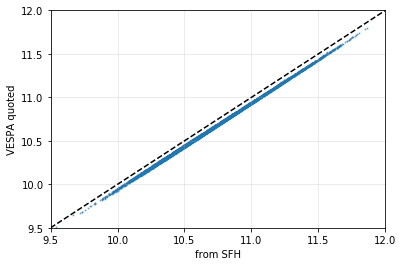

In [48]:
vespa_masses = sv.load_arr('vespa_mass','Subhalos')

vespa_sfh_masses = np.sum(predictors * vbinWidths \
                     * 1e9 * recycling_fraction_vespa, axis=1)

plt.scatter(np.log10(vespa_sfh_masses), np.log10(vespa_masses), s=1, label='VESPA', alpha=0.5)
plt.plot([9.5,12],[9.5,12], ls='dashed', c='black')
plt.xlabel('from SFH')
plt.ylabel('VESPA quoted')
plt.xlim(9.5, 12.0)
plt.ylim(9.5, 12.0)
plt.grid(alpha=0.3)

## Masses from SFH

Training predicted masses

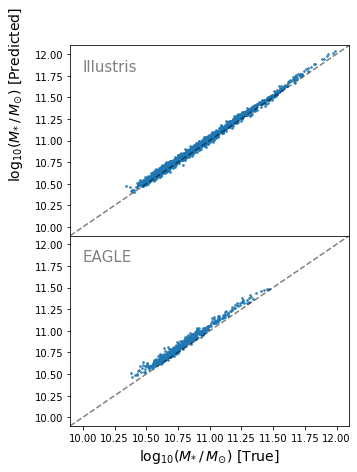

In [49]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5,7))
plt.subplots_adjust(hspace=0)

pred_mass = {}

mstar = si.load_arr('Stellar Mass 30kpc','Subhalos')[imask]
# mstar = np.array([value['stellar_mass_30'] for key,value in si.galaxies.items()])[i_mask]#[~si.train]
pred_mass['illustris'] = np.log10(np.sum(prediction['illustris-train'] * binWidths * recycling_fraction, axis=1))

ax1.scatter(mstar, pred_mass['illustris'], s=3, alpha=0.8)

ax1.text(10,11.8,'Illustris', alpha=0.5, size=15)

mstar = np.log10(se.load_arr('Stellar Mass 30kpc','Subhalos'))[emask]
# mstar = np.log10([value['stellar_mass_30'] for key,value in sq.galaxies.items()])[e_mask]#[~sq.train]
pred_mass['eagle'] = np.log10(np.sum(prediction['eagle-train'] * binWidths * recycling_fraction, axis=1))

ax2.scatter(mstar, pred_mass['eagle'], s=3, alpha=0.8)

ax2.text(10,11.8,'EAGLE', alpha=0.5, size=15)

for ax in [ax1,ax2]:
    ax.plot([9.9,12.1],[9.9,12.1],color='black',ls='dashed',alpha=0.5)
    ax.set_xlim(9.9,12.1)
    ax.set_ylim(9.9,12.1)


plt.text(-0.05,0.62, '$\mathrm{log_{10}}(M_{*} \,/\, M_{\odot})$ [Predicted]',
         transform=fig.transFigure, rotation=90, size=14)

ax2.set_xlabel('$\mathrm{log_{10}}(M_{*} \,/\, M_{\odot})$ [True]', size=14)
ax1.set_xticklabels([]);

# plt.savefig('plots/total_masses_test.png', dpi=250, bbox_inches='tight')

## Example

In [50]:
pred_mass['illustris-vespa'] = np.log10(np.sum(prediction['illustris'] * binWidths * recycling_fraction, axis=1))
pred_mass['eagle-vespa'] = np.log10(np.sum(prediction['eagle'] * binWidths * recycling_fraction, axis=1))
vespa_masses = np.log10(vespa_sfh_masses)

sorted_idx = np.argsort(np.abs(pred_mass['illustris-vespa'] - vespa_masses))

In [51]:
from methods.misc import total_error

/research/astro/highz/Students/Chris/Learning_SFHs/methods/misc.py:22: RuntimeWarning: invalid value encountered in log10
  sigma[i] = m2*np.log10(sfh[i])**2 + m1*np.log10(sfh[i]) + c


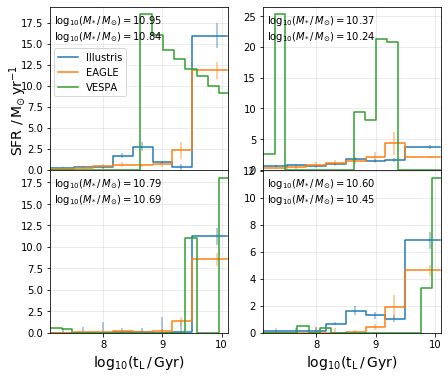

In [52]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(7,6))

plt.subplots_adjust(hspace=0)

axes = [ax1,ax2,ax3,ax4]
for ax,i in zip(axes,[sorted_idx[0],
                      sorted_idx[1],
                      sorted_idx[2],
                      sorted_idx[3]]):
    
    experiment_err_fits = pcl.load(open('data/experiment_err_fits_illustris.p','rb'))
    sigma_1_model = pcl.load(open('data/sigma_1_model_illustris.p','rb'))

    p = np.hstack([prediction['illustris'][i][0], prediction['illustris'][i]])
    ax.step(np.log10(binLimits * 1e9), p, label='Illustris', color='C0')
    
    tot_err = total_error(p[1:], experiment_err_fits, sigma_1_model, key='dust', fracs=False)
    ax.errorbar(np.log10(binLimits[1:] * 1e9)-0.18,
                p[1:], yerr=tot_err, alpha=0.5, color='C0', fmt='none')
    
    experiment_err_fits = pcl.load(open('data/experiment_err_fits_eagle.p','rb'))
    sigma_1_model = pcl.load(open('data/sigma_1_model_eagle.p','rb'))
    
    p = np.hstack([prediction['eagle'][i][0], prediction['eagle'][i]])
    ax.step(np.log10(binLimits * 1e9), p, label='EAGLE', color='C1')
    
    tot_err = total_error(p[1:], experiment_err_fits, sigma_1_model, key='dust', fracs=False)
    ax.errorbar(np.log10(binLimits[1:] * 1e9)-0.18,
                p[1:], yerr=tot_err, alpha=0.5, color='C1', fmt='none')

    p = np.hstack([predictors[i][0], predictors[i]])
    ax.step(np.log10(vbinLimits*1e9), p, label='VESPA', color='C2')
    
    ax.text(0.02,0.9,"$\mathrm{log_{10}}(M_{*} \,/\, M_{\odot}) = %.2f$"%(pred_mass['illustris-vespa'][i]), 
            transform=ax.transAxes)
    ax.text(0.02,0.8,"$\mathrm{log_{10}}(M_{*} \,/\, M_{\odot}) = %.2f$"%(pred_mass['eagle-vespa'][i]), 
            transform=ax.transAxes)

    ax.set_xlim(7.1,10.1)
    ax.set_ylim(0,)
    ax.grid(alpha=0.3)


ax1.legend(loc=(0.02,0.45))

for ax in [ax1,ax2]:
    ax.set_xticklabels([])
    
    
plt.text(0.04, 0.55, 'SFR $/\, \mathrm{M_{\odot} \, yr^{-1}}$', 
         size=14, transform=fig.transFigure, rotation=90)

for ax in [ax3,ax4]:
    ax.set_xlabel('$\mathrm{log_{10}(t_{L} \,/\, Gyr)}$', size=14)

# plt.savefig('plots/SDSS_SFH_comparison.png', dpi=250, bbox_inches='tight')

## Mass split

691
3122
2979
3208


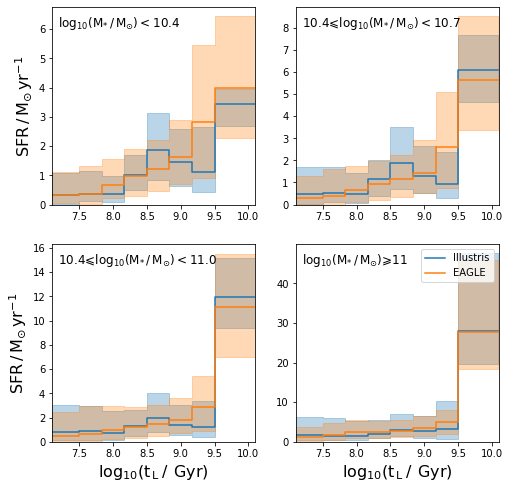

In [53]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,8))
mask1 = (pred_mass['illustris-vespa'] < 10.4)
mask2 = (pred_mass['illustris-vespa'] >= 10.4) & (pred_mass['illustris-vespa'] < 10.7)
mask3 = (pred_mass['illustris-vespa'] >= 10.7) & (pred_mass['illustris-vespa'] < 11.0)
mask4 = (pred_mass['illustris-vespa'] >= 11.0)

func = np.median

for mask,ax in zip([mask1,mask2,mask3,mask4],[ax1,ax2,ax3,ax4]):

#     perc = func(predictors[mask], axis=0)
#     perc = np.hstack([perc, np.array([perc[-1]]).T])
#     perc = np.percentile(predictors[mask], [16,50,84], axis=0)
#     perc = np.hstack([perc, np.array([perc[:,-1]]).T])
#     ax.step(np.log10(sp.binning['log']['binLimits'] * 1e9), perc[1], 
#             label='VESPA', where='post', color='C2') 
#     ax.fill_between(np.log10(sp.binning['log']['binLimits'] * 1e9), 
#                     perc[0], perc[2], alpha=0.3, color='C2')
    
#     perc = func(prediction['illustris'][mask], axis=0)
#     perc = np.hstack([perc, np.array([perc[-1]]).T])
    print(np.sum(mask))
    perc = np.percentile(prediction['illustris'][mask], [16,50,84], axis=0)
    perc = np.hstack([perc, np.array([perc[:,-1]]).T])
    ax.step(np.log10(binLimits * 1e9), perc[1], label='Illustris', where='post', color='C0')
    ax.fill_between(np.log10(binLimits * 1e9), 
                    perc[0], perc[2], alpha=0.3, color='C0', step='post')

#     perc = func(prediction['eagle'][mask], axis=0)
#     perc = np.hstack([perc, np.array([perc[-1]]).T])
    perc = np.percentile(prediction['eagle'][mask], [16,50,84], axis=0)
    perc = np.hstack([perc, np.array([perc[:,-1]]).T])
    ax.step(np.log10(binLimits * 1e9), perc[1], label='EAGLE', where='post', color='C1')
    ax.fill_between(np.log10(binLimits * 1e9), 
                    perc[0], perc[2], alpha=0.3, color='C1', step='post')


ax1.text(0.03, 0.9, '$\mathrm{log_{10}(M_{*}\,/\,M_{\odot}) < 10.4}$', 
         transform=ax1.transAxes, size=12)
ax2.text(0.03, 0.9, '$\mathrm{10.4 \leqslant log_{10}(M_{*}\,/\,M_{\odot}) < 10.7}$', 
         transform=ax2.transAxes, size=12)
ax3.text(0.03, 0.9, '$\mathrm{10.4 \leqslant log_{10}(M_{*}\,/\,M_{\odot}) < 11.0}$', 
         transform=ax3.transAxes, size=12)
ax4.text(0.03, 0.9, '$\mathrm{log_{10}(M_{*}\,/\,M_{\odot}) \geqslant 11}$', 
         transform=ax4.transAxes, size=12)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim(0,)
    ax.set_xlim(7.1,10.1)
    
for ax in [ax1,ax3]:
    ax.set_ylabel('$\mathrm{SFR \,/\, M_{\odot} \, yr^{-1}}$', size=16)

    
ax3.set_xlabel('$\mathrm{log_{10}(t_{\,L} \,/\, \;Gyr)}$', size=16)
ax4.set_xlabel('$\mathrm{log_{10}(t_{\,L} \,/\, \;Gyr)}$', size=16)

ax4.legend()

# fig.savefig('plots/SDSS_mass_split.png', dpi=250, bbox_inches='tight')

## Mass comparison

In [54]:
from scipy.stats import binned_statistic

binLimits = np.linspace(10, 11.8, 10)
bins = np.linspace(10.1, 11.7, 9)
print(bins, binLimits)

[10.1 10.3 10.5 10.7 10.9 11.1 11.3 11.5 11.7] [10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8]


/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


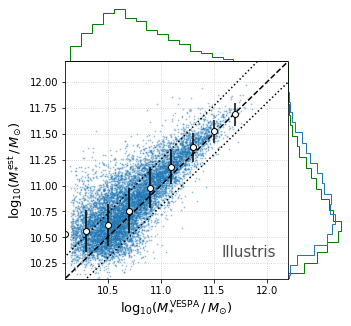

In [64]:
fig = plt.figure(figsize=(5,5))

gs = gridspec.GridSpec(5,5)

ax1 = fig.add_subplot(gs[1:,:4])
ax2 = fig.add_subplot(gs[0,:4])
ax3 = fig.add_subplot(gs[1:,4])
ax4 = fig.add_subplot(gs[1:,4])

gs.update(wspace=0, hspace=0) 

# # vespa_masses = np.log10([value['vespa_mass'] * value['vespa_mass_correction'] \

# vespa_masses = np.log10(vespa_sfh_masses)
# np.array([np.log10(value['vespa_mass']) for key, value in sp.galaxies.items()])
mask = vespa_masses > 10.15

ax2.hist(vespa_masses[mask], histtype='step', bins=20, color='green', 
         label='VESPA', density=True)

ax4.hist(vespa_masses[mask], histtype='step', bins=20, color='green', 
         label='VESPA', density=True, orientation='horizontal')


test_masses = np.log10(np.sum(prediction['illustris'] * binWidths * recycling_fraction, axis=1))
ax4.hist(test_masses[mask], histtype='step', bins=20, density=True, orientation='horizontal')

ax1.scatter(vespa_masses[mask], test_masses[mask], s=1, alpha=0.3) # label='Illustris'

medi, dummy, dummy = binned_statistic(vespa_masses[mask], test_masses[mask], 
                                      statistic=np.median, bins=binLimits)

perc, dummy, dummy = binned_statistic(vespa_masses[mask], test_masses[mask], 
    statistic=np.std, bins=binLimits)

ax1.errorbar(bins, medi, yerr=perc, fmt='o', alpha=1.0, c='black',
            fillstyle='full', markerfacecolor='white')

ax1.plot([10,12.5],[10,12.5], linestyle='dashed', color='black')
ax1.plot([10.2,12.2],[10,12], linestyle='dotted', color='black')
ax1.plot([9.8,12.2],[10,12.5], linestyle='dotted', color='black')

# leg = ax1.legend()
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)


ax1.set_ylabel('$\mathrm{log_{10}}(M^{\mathrm{est}}_{*} \,/\, M_{\odot})$', size=13)
ax1.set_xlabel('$\mathrm{log_{10}}(M^{\mathrm{VESPA}}_{*} \,/\, M_{\odot})$', size=13)

ax1.grid(ls='dotted', alpha=0.7)

for ax in [ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    
    
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax1.text(0.7, 0.1, 'Illustris', alpha=0.7, transform=ax1.transAxes, size=15)

for ax in [ax1,ax2]:
    ax.set_xlim(10.1,12.2)
    

for ax in [ax1,ax4]:
    ax.set_ylim(10.1,12.2)


# ax4.set_xlim(0, ax2.get_ylim()[1]);
    
# plt.savefig('plots/SDSS_mass_vespa_comparison_illustris.png', dpi=250, bbox_inches='tight')

/research/astro/highz/Students/Chris/Learning_SFHs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


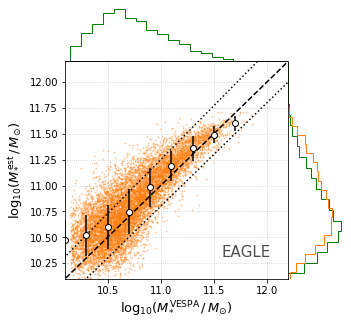

In [65]:
fig = plt.figure(figsize=(5,5))

gs = gridspec.GridSpec(5,5)

ax1 = fig.add_subplot(gs[1:,:4])
ax2 = fig.add_subplot(gs[0,:4])
ax3 = fig.add_subplot(gs[1:,4])
ax4 = fig.add_subplot(gs[1:,4])

gs.update(wspace=0, hspace=0) 

# # vespa_masses = np.log10([value['vespa_mass'] * value['vespa_mass_correction'] \

# vespa_masses = np.log10(vespa_sfh_masses)
# np.array([np.log10(value['vespa_mass']) for key, value in sp.galaxies.items()])
mask = vespa_masses > 10.15

ax2.hist(vespa_masses[mask], histtype='step', bins=20, 
         color='green', label='VESPA', density=True)

ax4.hist(vespa_masses[mask], histtype='step', bins=20, 
         color='green', label='VESPA', density=True, orientation='horizontal')


test_masses = np.log10(np.sum(prediction['eagle'] * binWidths * recycling_fraction, axis=1))
ax4.hist(test_masses[mask], histtype='step', bins=20, density=True, orientation='horizontal', color='C1')
ax1.scatter(vespa_masses[mask],test_masses[mask], s=1, alpha=0.3, c='C1') # label='EAGLE', 

medi, dummy, dummy = binned_statistic(vespa_masses[mask], test_masses[mask], 
                                      statistic=np.median, bins=binLimits)

perc, dummy, dummy = binned_statistic(vespa_masses[mask], test_masses[mask], 
    statistic=np.std, bins=binLimits)

ax1.errorbar(bins, medi, yerr=perc, fmt='o', alpha=1.0, c='black',
            fillstyle='full', markerfacecolor='white')

ax1.plot([10,12.5],[10,12.5], linestyle='dashed', color='black')
ax1.plot([10.2,12.2],[10,12], linestyle='dotted', color='black')
ax1.plot([9.8,12.2],[10,12.5], linestyle='dotted', color='black')

# leg = ax1.legend()
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)


ax1.set_ylabel('$\mathrm{log_{10}}(M^{\mathrm{est}}_{*} \,/\, M_{\odot})$', size=13)
ax1.set_xlabel('$\mathrm{log_{10}}(M^{\mathrm{VESPA}}_{*} \,/\, M_{\odot})$', size=13)

ax1.grid(ls='dotted', alpha=0.7)

for ax in [ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    
    
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax1.text(0.7, 0.1, 'EAGLE', alpha=0.7, transform=ax1.transAxes, size=15)

for ax in [ax1,ax2]:
    ax.set_xlim(10.1,12.2)
    

for ax in [ax1,ax4]:
    ax.set_ylim(10.1,12.2)


# ax4.set_xlim(0, ax2.get_ylim()[1]);
    
# plt.savefig('plots/SDSS_mass_vespa_comparison_eagle.png', dpi=250, bbox_inches='tight')